# Part 2 - Silence detection

In this notebook, you'll implement a basic silence detector.  This will introduce you to basic feature extraction and audio manipulation in python.

You can use this to segment speech recordings into short utterances, but the point is more to get you familiar with how it looks to process audio programmatically.

## Setup

Again, we begin by setting up our envrionment.  This time, we'll do it all in one block.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from IPython.display import Audio

In [2]:
# We'll work with an example provided in the repository.
# There are many files in this directory, but we'll start with the first one.
# The later examples (higher numbers) have more difficult noise conditions.

y, sr = librosa.load('silence_examples/2.wav')

In [3]:
# Play it back, so we know what our data sounds like
Audio(data=y, rate=sr)

In [4]:
# Let's visualize the spectrogram to see what the data looks like
D = librosa.stft(y)
S = np.abs(D)
S_db = librosa.amplitude_to_db(S, ref=np.max)

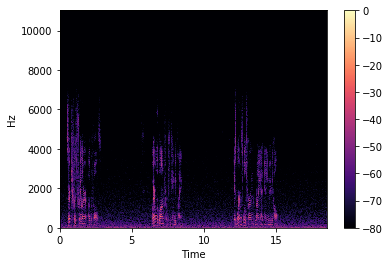

In [5]:
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
plt.colorbar()

# What can we see here?

- Where is the energy?
- How can we detect regions with high energy?

### The feature module

`librosa.feature` contains methods for extracting different descriptive features from audio.  These might encode aspects of loudness, rhythm, pitch, harmony, noisiness, etc.

As a first step, let's look at the "energy" in each time step as represented by the root-mean-square (RMS) values.  This is computed by `librosa.feature.rms`.

Feature methods can be applied to either the audio time series `(y)` or a pre-computed spectrogram `(S)`.

In [6]:
energy = librosa.feature.rms(S=S)

In [7]:
# What does this look like?
energy

array([[ 0.94341904,  1.5786601 ,  2.2104163 ,  2.4484384 ,  2.8886297 ,
         3.8906674 ,  4.575154  ,  4.657867  ,  5.327586  ,  7.29888   ,
         8.69539   ,  8.709568  ,  8.180014  ,  8.175498  ,  8.428822  ,
         8.416973  ,  8.16821   ,  7.7902513 ,  7.6321197 ,  7.1824403 ,
         6.6915393 ,  7.0124917 ,  7.7153654 ,  8.754314  ,  9.895626  ,
        11.196388  , 12.033498  , 11.96322   , 11.828491  , 12.2384405 ,
        12.527568  , 12.5049715 , 12.095643  , 11.472423  , 11.151349  ,
         9.974066  ,  9.735064  , 10.271723  , 10.582139  , 10.3528595 ,
        10.462852  , 10.694412  , 10.748553  , 10.074645  ,  9.430251  ,
         9.622466  , 10.81148   , 11.818698  , 11.586984  , 10.986906  ,
        11.120227  , 10.613688  , 10.709269  , 12.314294  , 12.809567  ,
        12.5489235 , 13.099948  , 13.616873  , 13.941478  , 13.775558  ,
        13.291535  , 12.278176  , 10.971792  , 10.535761  , 10.898768  ,
        11.54745   , 11.832174  , 11.497244  , 11.0

In [8]:
# Energy is a 2-dimensional array:
#  The first dimension indexes the feature(s) (energy)
#  The second dimension indexes the time axis.

# It's hard to read this directly, but we can visualize it with a plot using matplotlib.
# To do this, we'll want to know the times corresponding to each measurement.
# We can get this as follows:

times = librosa.times_like(energy)

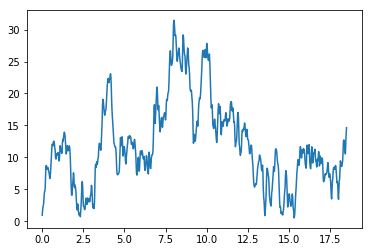

In [9]:
# Now we can plot the data
plt.plot(times, energy[0])

In [ ]:
# Or we can plot in decibels
plt.plot(times, librosa.amplitude_to_db(energy[0], ref=np.max))

# What does this show?

The `rms` function looks at the total energy within each frame of 2048 samples.

At the sampling rate of `sr=22050`, this corresponds to about 93ms of audio.

When we convert to decibels (relative to the maximum), we see that the energy is usually pretty high (during speech), and dips down low in between.  We can use this to determine a decibel threshold for determining silence.

In fact, we have a function built in that does exactly this calculation: you give it a decibel threshold, and it will return a list of time intervals (measured in samples) of detected regions that are above the threshold.  It's called `librosa.effects.split`.

In [10]:
librosa.effects.split(y=y, top_db=20)

array([[  2048,  46592],
       [ 52224,  55808],
       [ 58368,  68096],
       [ 70144, 297472],
       [300032, 306176],
       [307200, 318976],
       [324608, 332800],
       [334848, 336384],
       [339456, 408258]])

In [11]:
# To use it, first save the intervals into an array
intervals = librosa.effects.split(y=y, top_db=20)

In [12]:
# Now we can slice out the first interval
y_slice = y[intervals[0, 0]:intervals[0, 1]]

In [13]:
Audio(data=y_slice, rate=sr)

In [14]:
# And the second slice
y_slice2 = y[intervals[1, 0]:intervals[1, 1]]

In [15]:
Audio(data=y_slice2, rate=sr)

# Hmmm....

That doesn't work all that well.  What's going on?

Let's take a closer look at the spectrum.  In this case, we'll use a logarithmic frequency axis to get a better view of the low frequencies.


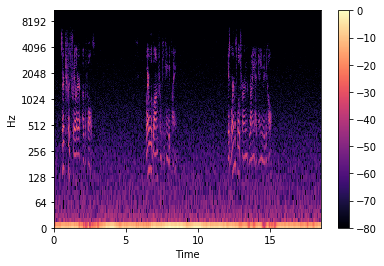

In [16]:
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()

### Noise!

These signals have a lot of energy in the low frequencies.

Let's use scipy to filter out the low frequencies.

In [17]:
import scipy.signal

In [18]:
# We'll make a high-pass, order-6 butterworth filter
# Let's put the cutoff at 64 Hz

# Don't worry about the details here: this is a pretty standard way
# to do filtering

b, a = scipy.signal.butter(6, 64, btype='high', fs=sr)

# Now that we have our coefficients, we can filter the signal
y_high = scipy.signal.filtfilt(b, a, y)

In [19]:
# Let's listen to our output
Audio(data=y_high, rate=sr)

In [20]:
# Now let's compute the spectrogram again and plot it
D_high = librosa.stft(y_high)
S_high = np.abs(D_high)
S_high_db = librosa.amplitude_to_db(S_high, ref=np.max)

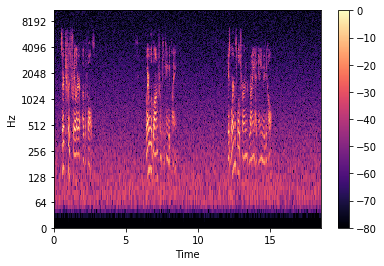

In [21]:
librosa.display.specshow(S_high_db, x_axis='time', y_axis='log')
plt.colorbar()

# No more low-frequency noise!

Let's see how that impacts our silence detection.

In [22]:
energy_high = librosa.feature.rms(S=S_high)

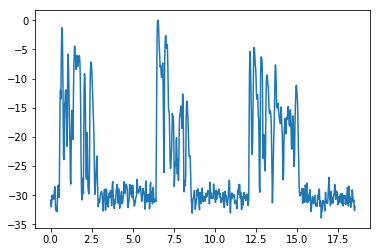

In [23]:
# Or we can plot in decibels
plt.plot(times, librosa.amplitude_to_db(energy_high[0], ref=np.max))

### That's much more like it!

In [24]:
new_splits = librosa.effects.split(y=y_high, top_db=30)

In [25]:
Audio(data=y[new_splits[0, 0]:new_splits[0, 1]], rate=sr)

In [26]:
Audio(data=y[new_splits[1, 0]:new_splits[1, 1]], rate=sr)

In [27]:
Audio(data=y[new_splits[2, 0]:new_splits[2, 1]], rate=sr)

# Wrapping up

In this notebook, you've done the following:

1. Computed features from audio and visualized the result
2. Implemented rules for splitting silence from non-silence
3. Iterated on the design by incorporating signal filtering

Once you've completed this part, try loading another example file.  Does the method still work, or does it need more refinement?  What might you do differently?